# Solving the Traveling Salesman  Problem using Local Search

Points: 10

## The [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

* __Goal:__ Find the shortest tour visiting each of $n$ cities exactly once and returning back to the starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$.

* __State space:__ Each state represents a tour. The cities are numbered and a tour can be expressed as vector  $\pi$ with the order in which the cities are visited (a [permutation](https://en.wikipedia.org/wiki/Permutation)). That is, $\pi(1)$ is the index of the first city to visit, $\pi(2)$ the index of the second, and so on.

* __Objective function:__ Minimize the tour length. The optimization problem is to find the optimal tour $\pi^*$ through the $n$ cities and returning to the starting city:

  > minimize: $\mathrm{tourlength}(\pi) = d_{\pi(n),\pi(1)} + \sum_{i = 1}^{n-1} d_{\pi(i),\pi(i+1)}$
  >
  > subject to: $\pi \ \text{is a valid permutation vector}$

* __Local moves:__ Exchange two cities in the order.

## Helper functions

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# make the results repeatable
np.random.seed(1234)

In [37]:
def random_tour(n):
    """Create a random tour"""

    tour = list(range(n))
    random.shuffle(tour) # xáo trộn các thành phố trong list
    return(tour)

random_tour(10)

[0, 8, 3, 7, 2, 9, 5, 1, 6, 4]

In [38]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a
    pairwise Euclidean distance matrix.
    """
    # sinh ngẩu nhiên tõa dô x, y trong khoãng [0, 1)
    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })
    # tính khoảng cách Euclidean cho tất cả cặp điểm
    dist = squareform(pdist(pos))

    return({"pos": pos, "dist": dist})

tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
      x     y
0  0.19  0.36
1  0.62  0.50
2  0.44  0.68
3  0.79  0.71
4  0.78  0.37
5  0.27  0.56
6  0.28  0.50
7  0.80  0.01
8  0.96  0.77
9  0.88  0.88
Distance matrix:
      0     1     2     3     4     5     6     7     8     9
0  0.00  0.45  0.41  0.69  0.59  0.22  0.17  0.70  0.87  0.86
1  0.45  0.00  0.26  0.27  0.20  0.35  0.35  0.52  0.43  0.46
2  0.41  0.26  0.00  0.35  0.46  0.21  0.24  0.76  0.53  0.48
3  0.69  0.27  0.35  0.00  0.34  0.53  0.55  0.70  0.18  0.19
4  0.59  0.20  0.46  0.34  0.00  0.54  0.52  0.36  0.44  0.52
5  0.22  0.35  0.21  0.53  0.54  0.00  0.06  0.76  0.72  0.68
6  0.17  0.35  0.24  0.55  0.52  0.06  0.00  0.72  0.73  0.71
7  0.70  0.52  0.76  0.70  0.36  0.76  0.72  0.00  0.77  0.87
8  0.87  0.43  0.53  0.18  0.44  0.72  0.73  0.77  0.00  0.14
9  0.86  0.46  0.48  0.19  0.52  0.68  0.71  0.87  0.14  0.00)


In [39]:
def tour_length(tsp, tour):
    """Caclulate the length of a tour, i.e., the objective function."""

    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()

    tl = 0
    dist = tsp["dist"] # distance matrix

    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]

    #thêm kcach tp cuối quay lại
    tl += dist[tour[-1], tour[0]]

    return(tl)

tour = random_tour(10)
tour_length(tsp, tour)

np.float64(4.87899109289446)

Tour length: 4.88


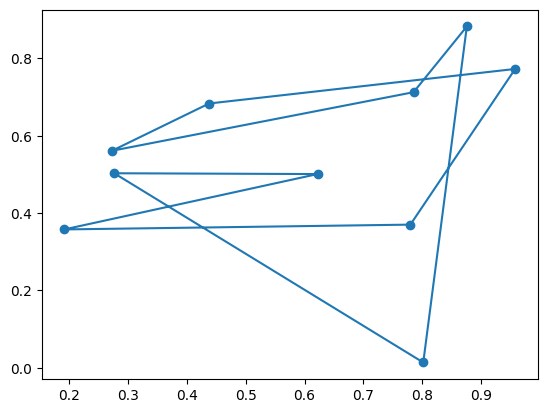

In [40]:
def show_tsp(tsp, tour = None):
    """display the traveling salesman problem and a tour."""

    pos = tsp["pos"] # tọa dô từng tp

    plt.scatter(pos["x"], pos["y"])

    if tour is not None:
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): tour = tour.tolist()

        print(f"Tour length: {round(tour_length(tsp, tour), 2)}")

        pos_ = pos.reindex(tour) # sắp xếp lại các tp theo tour
        pos_ = pd.concat([pos_, pos_.head(1)]) # thêm tp đầu vào cuối để vẽ quay đầu
        plt.plot(pos_["x"], pos_["y"])

    plt.show()

show_tsp(tsp, tour)

## Use R to find a solution

Load rpy2, make sure the R [TSP package](https://CRAN.R-project.org/package=TSP) is installed and prepare the distance matrix.

In [41]:
%load_ext rpy2.ipython

%R if(!"TSP" %in% rownames(installed.packages())) install.packages("TSP", repos="http://cran.us.r-project.org")
%R if(!"microbenchmark" %in% rownames(installed.packages())) install.packages("microbenchmark", repos="http://cran.us.r-project.org")

d = tsp["dist"]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Solve the TSP using [`solve_TSP`](https://www.rdocumentation.org/packages/TSP/versions/1.1-10/topics/solve_TSP) with the default heuristic. Note that 2-opt is steepest ascend hill climbing with exchanging two cities. `rep=100` means 100 random restarts.

In [42]:
%%R -i d -o tour

library("TSP")
# tạo đối tượng tsp trg R
tsp <- TSP(d)
print(tsp)

tour <- solve_TSP(tsp, rep = 100) # chạy 100 random restarts để cải thiện tour
print(tour)

# R starts index with 1, but Python starts at 0
tour <- tour - 1L

object of class ‘TSP’ 
10 cities (distance ‘unknown’) 
object of class ‘TOUR’ 
result of method ‘arbitrary_insertion+two_opt_rep_100’ for 10 cities
tour length: 2.763574 


Tour length: 2.76


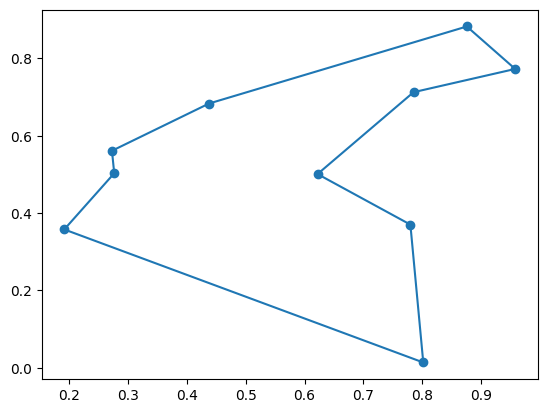

In [43]:
show_tsp(tsp, tour)

How long does it take to solve the problem 100 times?

In [44]:
%%R -i d
# benchmark toàn bộ quá trình giải TSP với 100 random restart
library("microbenchmark")

microbenchmark(tsp <- TSP(d))

Unit: microseconds
          expr     min      lq     mean   median      uq     max neval
 tsp <- TSP(d) 343.791 370.415 400.9427 384.3895 402.288 830.021   100


## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves.

Hàm tìm tất cả neighbor bằng swap 2 thành phố

In [45]:
def all_swaps(tour):
    """Sinh tất cả local moves bằng cách hoán đổi 2 thành phố"""
    n = len(tour)
    neighbors = []
    for i in range(n-1):
        for j in range(i+1, n):# từ kế i trở đi
            new_tour = tour.copy()
            new_tour[i], new_tour[j] = new_tour[j], new_tour[i] # đổi tp
            neighbors.append(new_tour)
    return neighbors


Steepest-Ascent Hill Climbing cho TSP

In [46]:
def steepest_ascent_hill_climbing(tsp, initial_tour):
    """Tìm tour tối ưu cục bộ bằng steepest-ascent hill climbing"""
    current_tour = initial_tour.copy()
    current_length = tour_length(tsp, current_tour)
    improved = True

    while improved:
        improved = False
        neighbors = all_swaps(current_tour)
        best_neighbor = current_tour
        best_length = current_length

        for neighbor in neighbors:
            length = tour_length(tsp, neighbor)
            if length < best_length:
                best_length = length
                best_neighbor = neighbor
                improved = True

        current_tour = best_neighbor
        current_length = best_length

    return current_tour, current_length


Thử nghiệm với tour ngẫu nhiên

Initial length: 4.320794024034573
Optimized length: 2.8810894251962416
Tour length: 2.88


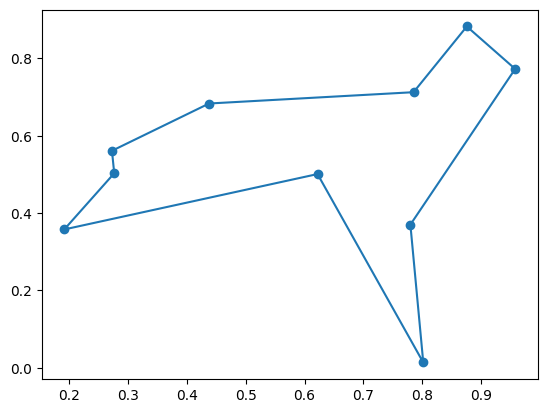

In [47]:
initial_tour = random_tour(len(tsp["pos"]))
print("Initial length:", tour_length(tsp, initial_tour))

best_tour, best_length = steepest_ascent_hill_climbing(tsp, initial_tour)
print("Optimized length:", best_length)

# Vẽ tour tối ưu
show_tsp(tsp, best_tour)


## Steepest-ascend Hill Climbing Search with Random Restarts [1 Point]

Steepest-ascend with random restarts.
Chạy ngẫu nhiên n_restarts lần

In [48]:
def steepest_ascent_hill_climbing_random_restarts(tsp, n_restarts=10):
    """Steepest-ascent Hill Climbing với random restarts"""
    best_tour = None
    best_length = float("inf")
    for i in range(n_restarts):
        #tự tạo tour mới
        initial_tour = random_tour(len(tsp["pos"]))
        tour, length = steepest_ascent_hill_climbing(tsp, initial_tour)

        if length < best_length:
            best_tour = tour
            best_length = length

        print(f"Restart {i+1}: tour length = {length:.2f}")

    print(f"\nBest tour length after {n_restarts} restarts: {best_length:.2f}")
    return best_tour, best_length


Restart 1: tour length = 2.76
Restart 2: tour length = 2.76
Restart 3: tour length = 2.76
Restart 4: tour length = 2.88
Restart 5: tour length = 2.81
Restart 6: tour length = 2.88
Restart 7: tour length = 2.79
Restart 8: tour length = 2.79
Restart 9: tour length = 2.76
Restart 10: tour length = 2.79

Best tour length after 10 restarts: 2.76
Tour length: 2.76


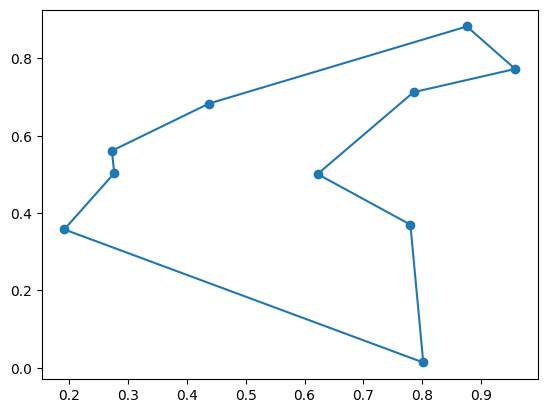

In [49]:
best_tour, best_length = steepest_ascent_hill_climbing_random_restarts(tsp, n_restarts=10)
show_tsp(tsp, best_tour)


## Stochastic Hill Climbing [1 Points]

Chooses randomly from among all uphill moves.

Loại các neighbor tối ưu yếu

In [50]:
def stochastic_hill_climbing(tsp, initial_tour, max_iter=1000):
    """Stochastic Hill Climbing cho TSP"""
    current_tour = initial_tour.copy()
    current_length = tour_length(tsp, current_tour)

    for iteration in range(max_iter):
        neighbors = all_swaps(current_tour)
        # Chọn tất cả các neighbor tốt hơn hiện tại
        better_neighbors = [tour for tour in neighbors if tour_length(tsp, tour) < current_length]

        if not better_neighbors:
            break

        # Chọn ngẫu nhiên một neighbor tốt hơn
        current_tour = random.choice(better_neighbors)
        current_length = tour_length(tsp, current_tour)

    return current_tour, current_length


Best tour length: 2.8810894251962416
Tour length: 2.88


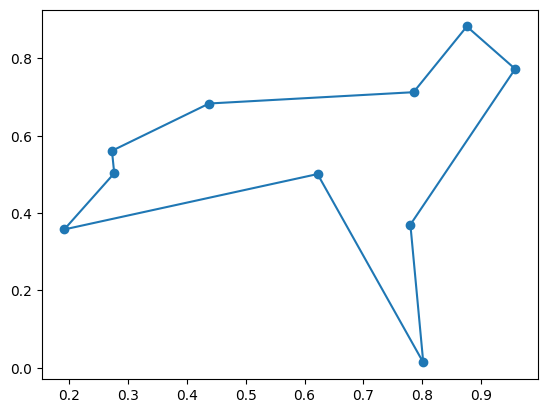

In [51]:
initinal_tour = random_tour(len(tsp['pos']))
best_tour, best_length = stochastic_hill_climbing(tsp, initinal_tour)
print(f"Best tour length: {best_length}")
show_tsp(tsp, best_tour)


## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state.

Thay vì tạo tất cả các neighbor cùng lúc,
Sinh ngẫu nhiên một neighbor (swap 2 thành phố) một lần,
Nếu neighbor tốt hơn (giảm chiều dài tour) → chấp nhận,
Ngược lại → giữ nguyên tour hiện tại, và tiếp tục thử neighbor khác, cho tới khi hết max iteration hoặc không còn cải thiện.

In [52]:
def first_choice_hill_climbing(tsp, initial_tour, max_iter=1000):
    """First-Choice Hill Climbing cho TSP"""
    current_tour = initial_tour.copy()
    current_length = tour_length(tsp, current_tour)
    n = len(current_tour)

    for i in range(max_iter):
      # lấy ngẫu nhiên 2 tp từ n( sl tp)
      i, j = random.sample(range(n), 2)
      neighbor = current_tour.copy()
      neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
      length = tour_length(tsp, neighbor)
      # sau khi chạy chỗ mà tối ưu hơn thì thay thế
      if length < current_length:
        current_tour = neighbor
        current_length = length

    return current_tour, current_length


Best tour length: 2.7865169894199324
Tour length: 2.79


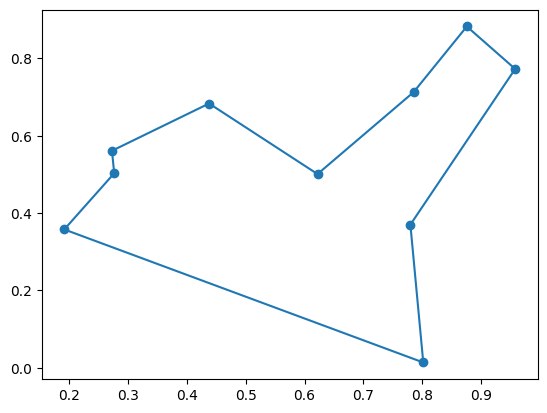

In [53]:
initinal_tour = random_tour(len(tsp['pos']))
best_tour, best_length = first_choice_hill_climbing(tsp, initinal_tour)
print(f"Best tour length: {best_length}")
show_tsp(tsp, best_tour)

## Simulated Annealing [2 Points]

Simulated Annealing (SA) là một mở rộng ngẫu nhiên của Hill Climbing, giúp thoát khỏi local optimum bằng cách đôi khi chấp nhận các move xấu (tăng độ dài tour) với xác suất giảm dần theo thời gian.

In [54]:
def simulated_annealing(tsp, initial_tour, T_start=1000, T_end=1e-3, alpha=0.995, max_iter=1000):
    """Simulated Annealing cho bài toán TSP"""
    current_tour = initial_tour.copy()
    current_length = tour_length(tsp, current_tour)
    best_tour = current_tour.copy()
    best_length = current_length
    n = len(current_tour)

    T = T_start

    for iteration in range(max_iter):
        # mỗi lần lặp giảm nhiệt độ, Khi nhiệt độ quá thấp → dừng lại
        T *= alpha
        if T < T_end:
            break

        # Sinh 1 neighbor ngẫu nhiên (swap 2 thành phố)
        i, j = random.sample(range(n), 2)
        neighbor = current_tour.copy()
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        neighbor_length = tour_length(tsp, neighbor)

        # delta: độ chênh lệch giữa neighbor và current.
        delta = neighbor_length - current_length

        # Xác suất tồn tại ở trạng thái năng lượng cao (xấu hơn) giảm theo hàm mũ khi năng lượng tăng.
        if delta < 0 or math.exp(-delta / T) > random.random():
            current_tour = neighbor
            current_length = neighbor_length

            # Cập nhật tour tốt nhất
            if current_length < best_length:
                best_tour = current_tour.copy()
                best_length = current_length

    return best_tour, best_length


T_start: nhiệt độ khởi đầu (cao → dễ chấp nhận lời giải xấu)

T_end: nhiệt độ kết thúc (thấp → chỉ chấp nhận lời giải tốt)

alpha: hệ số làm nguội (mỗi vòng lặp T = T * alpha)

max_iter: số vòng lặp tối đa




Nếu neighbor tốt hơn, ta luôn chấp nhận.

Nếu neighbor xấu hơn, ta vẫn có thể chấp nhận với xác suất

P=e
−
T
Δ
	​


Khi T lớn → dễ chấp nhận lời giải xấu (để thoát local minimum).

Khi T nhỏ → gần như không chấp nhận lời giải xấu.

Initial tour length: 4.796953103547065
Optimized tour length (Simulated Annealing): 3.050600802958613
Tour length: 3.05


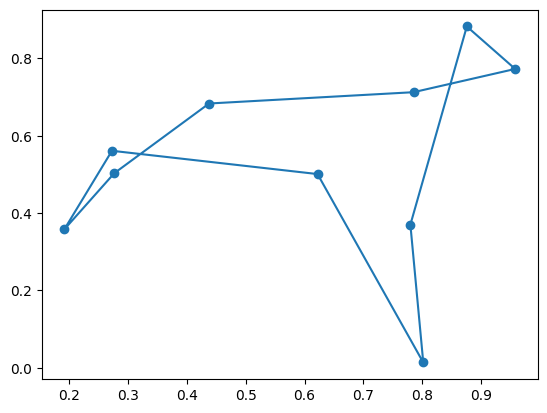

In [55]:
initial_tour = random_tour(len(tsp["pos"]))
print("Initial tour length:", tour_length(tsp, initial_tour))

best_tour_sa, best_length_sa = simulated_annealing(tsp, initial_tour)
print("Optimized tour length (Simulated Annealing):", best_length_sa)

show_tsp(tsp, best_tour_sa)


## Compare Performance [2 Points]

Use runtime, scalability (number of cities), and best objective function value to compare the algorithms on boards of different sizes.  

For timing you can use the `time` package.

In [56]:
import time

# Các thuật toán cần so sánh
algorithms = {
    "Steepest-Ascent": steepest_ascent_hill_climbing,
    "Stochastic": stochastic_hill_climbing,
    "First-Choice": first_choice_hill_climbing,
    "Simulated Annealing": simulated_annealing
}

sizes = [10, 20, 30, 40]  # số thành phố để test
results = []


In [57]:
for n in sizes:
    tsp = random_tsp(n)
    initial_tour = random_tour(n)

    for name, algo in algorithms.items():
        # thơi điểm bắt đầu
        t0 = time.time()
        best_tour, best_length = algo(tsp, initial_tour)
        t1 = time.time()

        runtime = (t1 - t0) * 1e3  # ms

        results.append({
            "Algorithm": name,
            "Cities": n,
            "Best Length": round(best_length, 2),
            "Runtime (ms)": round(runtime, 2)
        })


In [58]:
df_results = pd.DataFrame(results)
display(df_results)


,Algorithm,Cities,Best Length,Runtime (ms)
0,Steepest-Ascent,10,2.79,1.70
1,Stochastic,10,2.67,2.27
2,First-Choice,10,3.11,5.23
3,Simulated Annealing,10,3.33,5.33
4,Steepest-Ascent,20,5.37,25.50
5,Stochastic,20,4.82,49.71
6,First-Choice,20,5.83,8.05
7,Simulated Annealing,20,8.35,7.67
8,Steepest-Ascent,30,7.35,78.03
9,Stochastic,30,5.99,174.43


## Bonus: Genetic Algorithm [+1 Point]

In [59]:
def genetic_algorithm_tsp(tsp, pop_size=100, generations=200, mutation_rate=0.1):
    n = len(tsp["pos"])

    # --- Tạo quần thể ban đầu ---
    population = [random_tour(n) for _ in range(pop_size)]

    def fitness(tour):
        return 1 / tour_length(tsp, tour)  # fitness càng cao càng tốt

    def selection(pop):
        # Chọn theo roulette wheel
        weights = [fitness(t) for t in pop]
        return random.choices(pop, weights=weights, k=2)

    def crossover(parent1, parent2):
        # Ordered Crossover (OX)
        start, end = sorted(random.sample(range(n), 2))
        child = [None] * n
        child[start:end] = parent1[start:end]
        fill_values = [c for c in parent2 if c not in child]
        j = 0
        for i in range(n):
            if child[i] is None:
                child[i] = fill_values[j]
                j += 1
        return child

    def mutate(tour):
        if random.random() < mutation_rate:
            i, j = random.sample(range(n), 2)
            tour[i], tour[j] = tour[j], tour[i]
        return tour

    best_tour = min(population, key=lambda t: tour_length(tsp, t))
    best_length = tour_length(tsp, best_tour)

    # --- Vòng lặp tiến hóa ---
    for gen in range(generations):
        new_population = []
        for _ in range(pop_size):
            parent1, parent2 = selection(population)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)

        population = new_population

        # Cập nhật best
        current_best = min(population, key=lambda t: tour_length(tsp, t))
        current_length = tour_length(tsp, current_best)
        if current_length < best_length:
            best_tour = current_best
            best_length = current_length

    return best_tour, best_length


Optimized tour length (Genetic Algorithm): 2.975497494917244
Tour length: 2.98


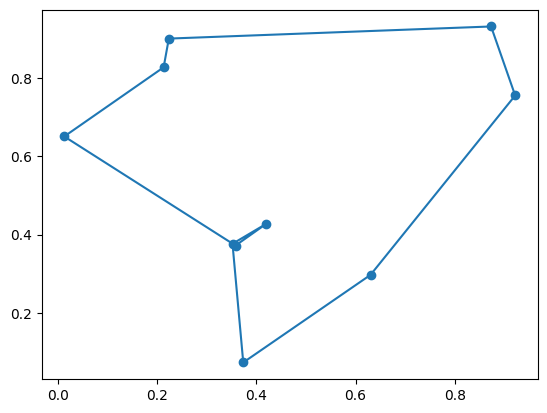

In [60]:
tsp = random_tsp(10)
initial_tour = random_tour(len(tsp["pos"]))

best_tour_ga, best_length_ga = genetic_algorithm_tsp(tsp, pop_size=100, generations=300)
print("Optimized tour length (Genetic Algorithm):", best_length_ga)

show_tsp(tsp, best_tour_ga)
